In [34]:
import os
import pandas as pd
import numpy as np
import preprocessing as proc
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

pd.options.display.max_columns = 1000

DATA_PATH = '../cell-profiler/measurements'
SUFFIX = 'morph_'
intensity = False
texture = False
zernike = True

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [35]:
measurements = proc.cell_data(data_path=DATA_PATH, suffix=SUFFIX, cytoplasm=False, biomarkers=False)

Total number of cells processed: 612.0

The numbers of cells and nuclei correspond to each other
The are no repeated column names: True
The are no repeated column names: True
Membrane features: (612, 68)
Chromatin features: (612, 68)
Full dataset has shape: (612, 129)


In [36]:
measurements = proc.clean_data(measurements, intensity)

Initial shape is: (612, 129)
Features with zero variance:
 Index(['centerZ_cell', 'eulernumber_cell', 'children_cytoplasm_count_cell',
       'loc_centerZ_cell', 'centerZ_nucl', 'eulernumber_nucl',
       'children_cytoplasm_count_nucl', 'loc_centerZ_nucl'],
      dtype='object')

After cleaning the dataset has 612 rows and 110 columns.



In [37]:
measurements_ = proc.drop_corr_features(measurements, intensity, texture, zernike)

Drop selected features with high Pearson's correlation coefficient.

Selected 10 cell shape features.
Selected 29 cell zernike features:
Selected 5 cell neighbours features.
Selected 9 nuclear shape features.
Selected 30 nuclear zernike features:
Selected 4 nuclear neighbours features.
Selected 3 distance measurement features.

After selecting features the dataset has 612 rows and 97 columns.



In [38]:
# Columns containing features
feature_cols = measurements_.select_dtypes(include=[np.number]).columns

In [39]:
measurements_syn = proc.smote(measurements_[feature_cols], measurements_.stiffness)


After synthesising new observations the balanced dataset has 1148 rows and 90 columns.



## Summary

In [ ]:
measurements.head(3)

In [ ]:
list(measurements.columns)

In [ ]:
measurements.info()

### Cells per stiffness value

In [ ]:
measurements_syn.groupby('stiffness').size()

In [ ]:
cell_numbers = measurements.groupby(['stiffness', 'well', 'site'], as_index=False)[['object']].count()
cell_numbers.groupby('stiffness').mean()

### Cells per image (density)

In [ ]:
sns.barplot(x="stiffness", y="object", data=cell_numbers, ci='sd');
plt.xlabel("Stiffness")
plt.ylabel("Count")
plt.title("Number of Cells per Image")
plt.savefig('../results/Cells per image.png', bbox_inches='tight', dpi=300);

### Descriptive statistics

In [ ]:
measurements.describe()

In [ ]:
measurements.describe(include=['object'])

## Correlations

Plate-layout-effect and batch-effect corrections

> To add heat maps of the correlations between all of wells within an experiment.

### Correlations between replicates

In [ ]:
measurements_.groupby(['stiffness_num', 'well']).sum()

> Calculate the correlations between replicates.

### Correlation with stiffness

In [ ]:
# Create numeric stiffness variable and define feature columns
measurements_syn['stiffness_num'] = pd.to_numeric(measurements_syn.stiffness)
numeric_cols = measurements_syn.select_dtypes(include=[np.number]).columns
feature_cols = measurements_syn.select_dtypes(include=[np.number]).drop(['stiffness_num'], axis=1).columns

#### Pearson's correlation

In [ ]:
p_corr = measurements_syn.corr();
p_corr.head(5)

In [ ]:
sns.set(rc={'figure.figsize':(15, 2)})

sns.heatmap(p_corr[['stiffness_num']].T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);

#plt.savefig('../results/Corr with Stiffness SMOTE.png', bbox_inches='tight', dpi=300);

#### Spearman's correlation

In [ ]:
s_corr = measurements_syn.corr(method='spearman');
s_corr.head(5)

In [ ]:
sns.set(rc={'figure.figsize':(15, 2)})

sns.heatmap(s_corr[['stiffness_num']].T, 
            cmap=sns.color_palette("RdBu_r", 100), 
            vmin=-1, vmax=1);
#plt.savefig('../results/Corr with Stiffness.png', bbox_inches='tight', dpi=300);

### Difference between Spearman's and Pearson's

In [ ]:
(s_corr - p_corr)[['stiffness_num']].plot(kind='bar', figsize=(15, 5));
#plt.savefig('../results/Spearman-Pearson SMOTE.png', bbox_inches='tight', dpi=300);

## Resampling

In [ ]:
measurements_ = resampling.smote(measurements_, feature_cols)

## Standardisation

In [40]:
measurements_norm = measurements_syn.copy()
# Standardise the entire dataset
measurements_norm[feature_cols] = (measurements_norm[feature_cols] - measurements_norm[feature_cols].mean()) / measurements_norm[feature_cols].std()
measurements_norm.head(3)

,area_cell,compactness_cell,eccentricity_cell,extent_cell,formfactor_cell,meanradius_cell,minoraxislength_cell,orientation_cell,perimeter_cell,solidity_cell,zernike_1_1_cell,zernike_2_0_cell,zernike_2_2_cell,zernike_1_cell,zernike_3_cell,zernike_4_0_cell,zernike_4_2_cell,zernike_4_4_cell,zernike_5_1_cell,zernike_5_cell,zernike_5_5_cell,zernike_6_0_cell,zernike_6_2_cell,zernike_6_4_cell,zernike_6_6_cell,zernike_7_1_cell,zernike_7_cell,zernike_7_5_cell,zernike_7_7_cell,zernike_8_0_cell,zernike_8_2_cell,zernike_8_4_cell,zernike_8_6_cell,zernike_8_8_cell,zernike_9_1_cell,zernike_9_cell,zernike_9_5_cell,zernike_9_7_cell,zernike_9_9_cell,anglebetweenneighbors_cell,firstclosestdistance_cell,numberofneighbors_cell,percenttouching_cell,secondclosestdistance_cell,area_nucl,compactness_nucl,eccentricity_nucl,extent_nucl,formfactor_nucl,majoraxislength_nucl,meanradius_nucl,orientation_nucl,solidity_nucl,zernike_0_0_nucl,zernike_1_1_nucl,zernike_2_0_nucl,zernike_2_2_nucl,zernike_1_nucl,zernike_3_nucl,zernike_4_0_nucl,zernike_4_2_nucl,zernike_4_4_nucl,zernike_5_1_nucl,zernike_5_nucl,zernike_5_5_nucl,zernike_6_0_nucl,zernike_6_2_nucl,zernike_6_4_nucl,zernike_6_6_nucl,zernike_7_1_nucl,zernike_7_nucl,zernike_7_5_nucl,zernike_7_7_nucl,zernike_8_0_nucl,zernike_8_2_nucl,zernike_8_4_nucl,zernike_8_6_nucl,zernike_8_8_nucl,zernike_9_1_nucl,zernike_9_nucl,zernike_9_5_nucl,zernike_9_7_nucl,zernike_9_9_nucl,anglebetweenneighbors_nucl,firstclosestdistance_nucl,numberofneighbors_nucl,secondclosestdistance_nucl,fartherstpoint_cell,fartherstpoint_nucl,nucleusshift,stiffness
0,0.942263,0.415925,0.962490,-0.301061,-0.646447,0.262119,-0.051310,0.399082,0.759180,-0.331748,-1.656453,-0.448867,-0.394500,-0.830321,-1.421397,1.608676,0.286805,0.643972,0.332099,-1.266171,-1.244409,1.938124,0.622546,1.265752,1.395586,0.664160,-1.452684,-0.813960,-1.247088,0.385601,1.297831,1.088589,2.029473,1.757941,0.204707,-1.162728,-0.350179,-0.882536,-1.537924,-0.973039,-0.413368,-0.137880,-0.607522,0.035078,1.395256,-0.841055,-0.403741,1.004221,0.817813,0.712651,1.802910,-0.177855,0.696462,1.039338,-0.777611,-0.090926,0.184785,-0.697505,-0.772097,1.258222,-1.020506,-1.455095,0.150160,-0.643012,-1.048099,-0.961178,1.082453,1.556891,-1.589938,-1.282867,-1.505727,-0.130093,-0.482813,0.321980,1.893697,-1.656968,0.383750,-1.662711,0.775975,0.188286,-0.394896,-1.887641,-0.992114,-0.945193,-0.504985,-0.411823,0.273159,-0.150739,-0.478670,-0.618200,0.2
671,-0.149593,0.161850,0.966597,-0.256280,-0.018269,-0.308125,-0.874453,-0.270069,-0.268976,1.020398,-1.288374,-0.215762,0.286307,-0.637317,-1.089821,1.426448,0.969017,1.335893,0.135152,-0.692182,-0.514282,1.383199,1.197522,1.740401,1.892290,0.569850,-0.451222,-0.254542,-0.075719,-0.326843,1.049282,1.134427,2.077226,1.914694,-0.173264,-0.618419,-0.667636,-0.021618,0.332829,-1.263606,-0.192331,-0.137880,0.021164,-0.219052,0.285479,1.069670,0.970258,-1.463408,-1.534830,0.982270,-0.195225,-0.157115,-0.586420,-1.533643,0.233320,0.556871,-0.110615,1.991665,-1.122427,-0.520814,0.751005,1.573710,0.162251,-1.139111,-0.841956,-0.672532,-1.439489,2.949149,1.894575,1.312528,0.458305,0.556259,-1.039486,-1.418124,-0.943470,-1.495456,-0.513042,2.293856,2.579160,0.262194,0.771629,0.054355,-0.615537,-0.609506,0.067363,-0.411823,-0.481079,-0.648496,-0.486661,-0.416625,0.2
670,1.792215,-0.324359,0.475353,-0.427824,-0.187574,1.761323,1.443868,0.623883,0.791302,-0.427565,0.644458,0.042419,0.746691,0.601590,1.487684,-0.807056,1.503650,-0.524353,1.140870,0.426864,0.721645,-1.379937,0.865034,-1.050102,-0.189397,1.316655,-0.493575,-0.146829,-0.629433,-1.018429,-2.048674,1.764050,-1.143197,-0.521659,0.363170,-0.179251,1.626136,0.298331,-0.780014,-0.761994,-0.387478,0.933228,-0.204337,-0.388727,1.032774,-0.897936,-3.062827,0.224081,-1.563621,-0.046698,1.211386,0.888002,-0.759440,1.217146,-0.907064,-0.403246,-2.806019,-0.428797,-0.349637,2.577541,-1.138355,-1.083725,-1.143057,-1.344982,-0.059439,1.822399,-1.698305,-1.140381,0.870901,-0.326006,-0.588322,-0.296219,0

### Visualise all the features

In [ ]:
sns.set(rc={'figure.figsize':(15, 12)})

sns.heatmap(measurements_norm[feature_cols],
            vmin = -2, vmax = 2,
            cmap=sns.color_palette("RdBu_r", 100),
            cbar_kws={"aspect": 20},
            xticklabels=False, yticklabels=False);

#plt.savefig('../results/Morphological features heatmap.png', bbox_inches='tight', dpi=300);

### Visualise aggregated values

In [ ]:
sns.set(rc={'figure.figsize':(15, 3)})

mean_per_stiffness = measurements_norm.groupby('stiffness')[feature_cols].mean()

sns.heatmap(mean_per_stiffness, 
            vmin = -1, vmax = 1,
            cmap=sns.color_palette("PRGn", 100), 
            cbar_kws={"aspect": 5},
            xticklabels=True, yticklabels=True);

#plt.savefig('../results/Aggregated feature heatmap.png', bbox_inches='tight', dpi=300);

In [ ]:
mean_per_stiffness

## Clustering

> `sns.clustermap(metric="correlation")` doesn't work. Will getting rid of redundant features help?

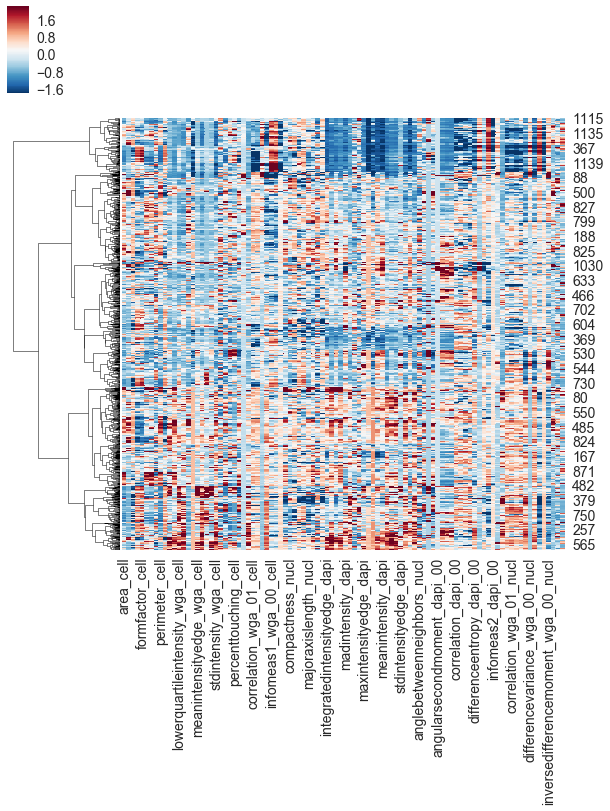

In [9]:
sns.clustermap(measurements_norm[feature_cols], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True);

['0.2', '0.5', '2.0', '8.0', '16.0', '32.0', '64.0']


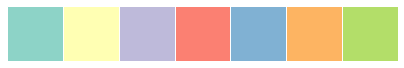

In [42]:
# Prepare a vector of colours mapped to the 'stiffness' column
my_palette = dict(zip(measurements_norm.stiffness.unique(), sns.color_palette("Set3", 7)))
row_colors = measurements_norm.stiffness.map(my_palette)

print(list(my_palette.keys()))
sns.palplot(my_palette.values());
#plt.savefig('../results/Palette.png', bbox_inches='tight', dpi=300);

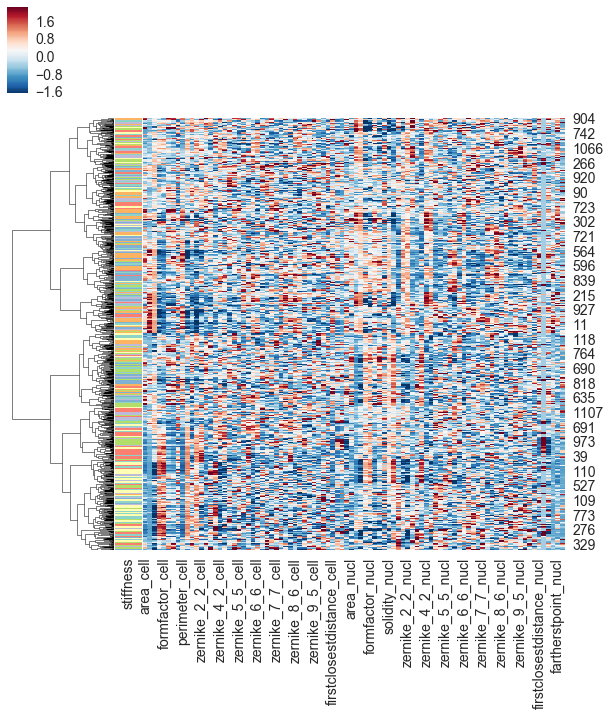

In [43]:
sns.clustermap(measurements_norm[feature_cols], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 100), robust=True, 
               row_colors=row_colors);

#plt.savefig('../results/Clustering.png', bbox_inches='tight', dpi=300);

## PCA

In [44]:
# Separating out the features
X = measurements_.loc[:, feature_cols].values

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(612, 90)

In [45]:
n_components = 50
# Create a PCA object
pca = PCA(n_components=n_components)

# Apply PCA to the scaled feature matrix
principal_components = pca.fit_transform(X_scaled)

pc_cols = [('pc_' + str(i)) for i in range(1, n_components + 1)]
#pc_df = pd.concat([measurements_.loc[:, 'label' : 'well'],
#                  pd.DataFrame(data = principal_components, columns = pc_cols)], 
#                  axis=1)
pc_df = pd.concat([measurements_.loc[:, 'stiffness'],
                  pd.DataFrame(data = principal_components, columns = pc_cols)], 
                  axis=1)

pc_df.shape

(612, 51)

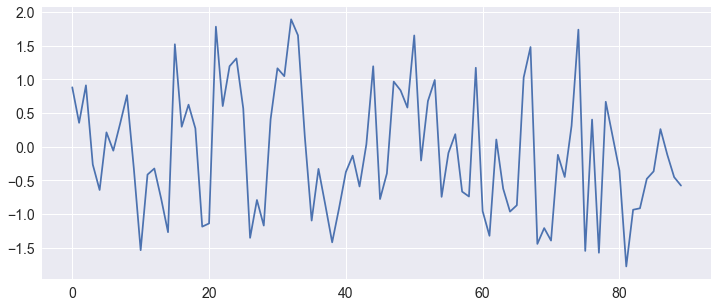

In [46]:
plt.rcParams['figure.figsize'] = (12, 5)

plt.plot(X_scaled[0]);

In [47]:
print(pca.explained_variance_.shape)
print("Percentage of explained variance:\n", 100 - pca.explained_variance_)
n_pc = sum(100 - pca.explained_variance_ < 98.0) + 1
print("\nThe first {} principal components explain {} variance".
      format(n_pc, 100 - pca.explained_variance_[n_pc-1]))

(50,)
Percentage of explained variance:
 [89.98435123 92.85246157 94.49470289 95.19254608 95.76050441 96.54542584
 97.28467509 97.49941484 97.61838706 97.92063219 98.07850947 98.13873301
 98.17525041 98.37615459 98.50290643 98.56362196 98.59894384 98.67018131
 98.73575498 98.75306431 98.8275307  98.89890221 98.94262142 98.98357811
 99.01487757 99.02827858 99.06812706 99.11466451 99.13026293 99.16891132
 99.17340668 99.21982848 99.22709391 99.24688775 99.2655231  99.29422137
 99.32164891 99.33469879 99.35230831 99.36693242 99.40411407 99.40510217
 99.42744298 99.44279057 99.46019162 99.48598616 99.49765822 99.52824122
 99.5413541  99.55725233]

The first 11 principal components explain 98.07850946575536 variance


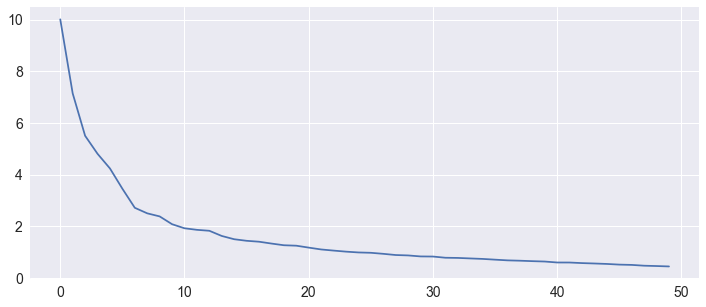

In [48]:
plt.plot(pca.explained_variance_);

#plt.savefig('../results/Explained variance.png', bbox_inches='tight', dpi=300);

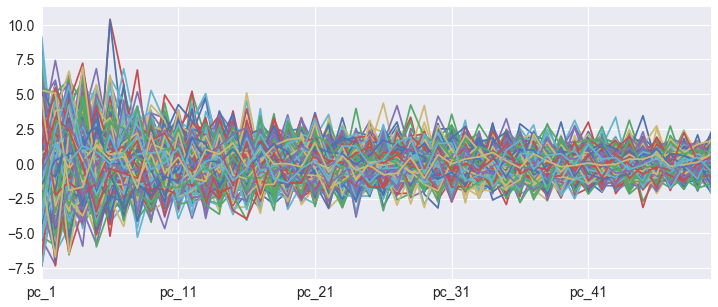

In [49]:
pc_df[pc_cols].T.plot(legend=False);

#plt.savefig('../results/Principal components.png', bbox_inches='tight', dpi=300);

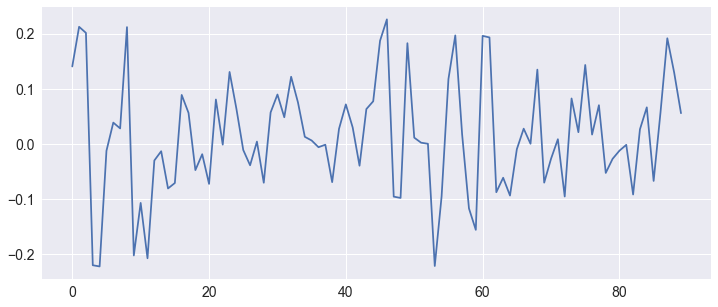

In [50]:
plt.plot(pca.components_[0]);

In [51]:
first_component = zip(feature_cols, pca.components_[0])

for col, weight in first_component:
    if abs(weight) > 0.2:
        print(col, weight)

compactness_cell 0.21261298063006517
eccentricity_cell 0.20160002687272582
extent_cell -0.21948618212899737
formfactor_cell -0.22166669130519703
perimeter_cell 0.2120148299916988
solidity_cell -0.20178467438485206
zernike_2_0_cell -0.2068759319602378
eccentricity_nucl 0.2261070058182392
zernike_0_0_nucl -0.22090663519745407


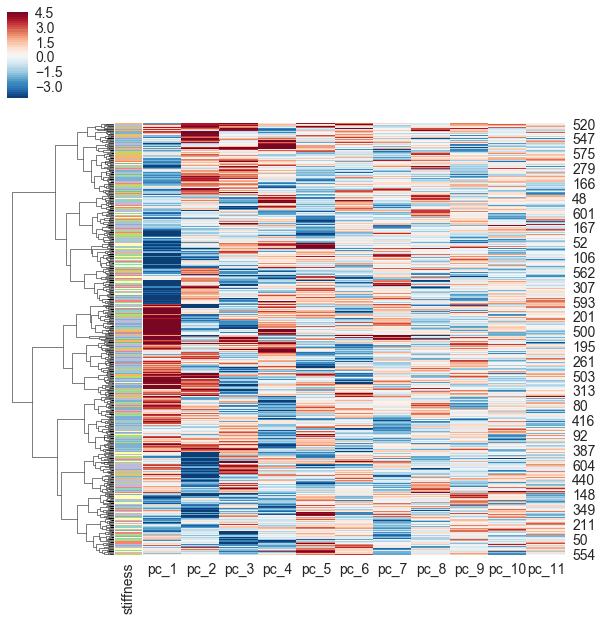

In [52]:
my_palette = dict(zip(pc_df.stiffness.unique(), sns.color_palette("Set3", 7)))
row_colors = pc_df.stiffness.map(my_palette)

sns.clustermap(pc_df.loc[:,'pc_1' : 'pc_' + str(n_pc)], 
               metric='euclidean', method='ward', 
               col_cluster=False,
               cmap=sns.color_palette('RdBu_r', 40), robust=True, 
               row_colors=row_colors);

#plt.savefig('../results/PCA Clustering 12.png', bbox_inches='tight', dpi=300);

## Random Forest Classifier

In [53]:
X = measurements_[feature_cols]
y = measurements_.stiffness
 
X.shape, y.shape

((612, 90), (612,))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((459, 90), (153, 90))

In [55]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='macro'))

Testing accuraccy: 0.40522875816993464
Testing f-score: 0.28496483339098355


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
np.unique(y_test, return_counts=True)

(array(['0.2', '0.5', '16.0', '2.0', '32.0', '64.0', '8.0'], dtype=object),
 array([21, 23, 19, 48, 11, 20, 11]))

In [58]:
np.unique(y_pred, return_counts=True)

(array(['0.2', '0.5', '16.0', '2.0', '32.0', '64.0'], dtype=object),
 array([ 5, 21, 35, 70,  7, 15]))

In [59]:
labels = y_test.unique().sort_values()
confusion = confusion_matrix(y_test, y_pred, labels=labels)
confusion_df = pd.DataFrame(confusion, columns=labels, index=labels)
confusion_df

,0.2,0.5,2.0,8.0,16.0,32.0,64.0
0.2,0,2,13,0,4,2,0
0.5,2,11,7,0,0,0,3
2.0,2,3,32,0,9,1,1
8.0,0,3,4,0,3,0,1
16.0,0,0,5,0,12,1,1
32.0,1,0,0,0,4,2,4
64.0,0,2,9,0,3,1,5


In [60]:
feature_importance = zip(feature_cols, rfc.feature_importances_)

for col, weight in feature_importance:
    if (weight > 0.02):
        print(col, weight)

area_cell 0.02111069668777261
perimeter_cell 0.021952827246816863
firstclosestdistance_cell 0.020220926477244983
secondclosestdistance_cell 0.020241466522450086
secondclosestdistance_nucl 0.020016378101652688


### Undersampling

In [ ]:
measurements_under = resampling.undersample(measurements_)
X = measurements_under[feature_cols]
y = measurements_under.stiffness
 
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='weighted'))

### SMOTE

In [61]:
measurements_.groupby('stiffness').size()

stiffness
0.2      83
0.5      78
2.0     164
8.0      49
16.0     97
32.0     55
64.0     86
dtype: int64

In [62]:
X = measurements_[feature_cols]
y = measurements_.stiffness
 
X.shape, y.shape

((612, 90), (612,))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train.shape, X_test.shape

((459, 90), (153, 90))

In [64]:
X_train_sm, y_train_sm = proc.smote(X_train, y_train, as_df=False)


After synthesising new observations the balanced dataset has 882 rows and 90 columns.



In [65]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_sm, y_train_sm)
y_pred = rfc.predict(X_test)
print("Testing accuraccy:", accuracy_score(y_test, y_pred))
print("Testing f-score:", f1_score(y_test, y_pred, average='weighted'))

Testing accuraccy: 0.3660130718954248
Testing f-score: 0.34430309201551035


In [66]:
labels = y_test.unique().sort_values()
confusion = confusion_matrix(y_test, y_pred, labels=labels)
confusion_df = pd.DataFrame(confusion, columns=labels, index=labels)
confusion_df

,0.2,0.5,2.0,8.0,16.0,32.0,64.0
0.2,2,2,14,2,1,2,2
0.5,0,9,2,1,1,0,3
2.0,2,6,20,1,6,1,2
8.0,1,3,2,4,0,0,3
16.0,2,2,4,0,13,5,0
32.0,1,1,1,0,5,4,2
64.0,0,1,10,0,2,4,4


In [67]:
feature_importance = zip(feature_cols, rfc.feature_importances_)

for col, weight in feature_importance:
    if (weight > 0.02):
        print(col, weight)

area_cell 0.027209094824276157
perimeter_cell 0.024957035539566443
formfactor_nucl 0.020975649677814606
secondclosestdistance_nucl 0.020235584120180273


## k-Means

In [68]:
X = measurements_syn[feature_cols]
#X = measurements_syn.loc[measurements_syn.stiffness != "8.0", feature_cols]

X.shape

(1148, 90)

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [73]:
km = KMeans(n_clusters=2, random_state=1)
km.fit(X_scaled)

measurements_syn['cluster'] = km.labels_
#measurements_syn.loc[measurements_syn.stiffness != "8.0",'cluster'] = km.labels_

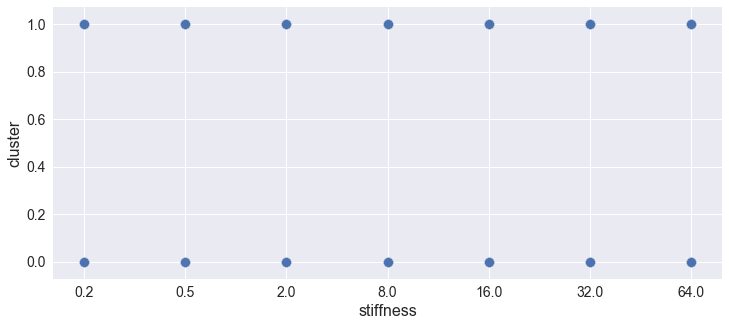

In [74]:
sns.scatterplot(data=measurements_syn, x='stiffness', y='cluster', 
                palette=sns.color_palette("husl", 7), 
                alpha=0.1, s=100);

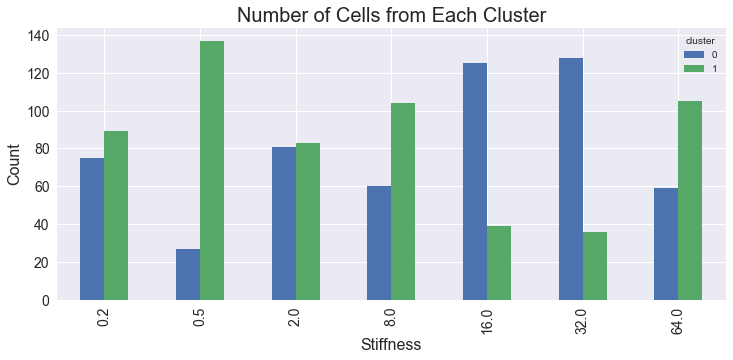

In [76]:
pd.crosstab(measurements_syn.stiffness, 
            measurements_syn.cluster).plot(kind='bar');
plt.xlabel("Stiffness")
plt.ylabel("Count")
plt.title("Number of Cells from Each Cluster");
plt.savefig('../results/Two clusters - morph only.png', bbox_inches='tight', dpi=300);

### All neighbours

In [78]:
cells = proc.load_data('tmp_neighbours_Cells.csv')
neighb = proc.load_data('tmp_neighbours_Neighbours.csv')

In [79]:
cells.head()

,ImageNumber,ObjectNumber,Metadata_Combination,Metadata_Combination.1,Metadata_Frame,Metadata_Series,Metadata_Site,Metadata_Site.1,Metadata_Stiffness,Metadata_Stiffness.1,Metadata_Well,Metadata_Well.1,Location_Center_X,Location_Center_Y,Location_Center_Z,Neighbors_AngleBetweenNeighbors_3,Neighbors_FirstClosestDistance_3,Neighbors_FirstClosestObjectNumber_3,Neighbors_NumberOfNeighbors_3,Neighbors_PercentTouching_3,Neighbors_SecondClosestDistance_3,Neighbors_SecondClosestObjectNumber_3,Number_Object_Number
0,1,1,B,B,0,0,1,1,0.2,0.2,A1,A1,440.701975,299.864220,0,38.051430,156.885865,4,1.0,2.267895,282.032105,3,1
1,1,2,B,B,0,0,1,1,0.2,0.2,A1,A1,773.934797,447.441401,0,102.713970,228.888442,5,2.0,8.355556,364.449089,1,2
2,1,3,B,B,0,0,1,1,0.2,0.2,A1,A1,217.642842,472.452550,0,31.388444,185.661593,4,0.0,0.000000,282.032105,1,3
3,1,4,B,B,0,0,1,1,0.2,0.2,A1,A1,402.168276,451.944227,0,110.560126,156.885865,1,0.0,0.000000,185.661593,3,4
4,1,5,B,B,0,0,1,1,0.2,0.2,A1,A1,729.582962,671.991693,0,67.268820,228.888442,2,1.0,4.788069,394.488611,4,5


In [110]:
neighb.columns

Index(['ImageNumber', 'Location_Center_X', 'Location_Center_Y',
       'Location_Center_Z', 'Neighbors_AngleBetweenNeighbors_3',
       'Neighbors_FirstClosestDistance_3',
       'Neighbors_FirstClosestObjectNumber_3', 'Neighbors_NumberOfNeighbors_3',
       'Neighbors_PercentTouching_3', 'Neighbors_SecondClosestDistance_3',
       'Neighbors_SecondClosestObjectNumber_3', 'Number_Object_Number'],
      dtype='object')

In [107]:
loc_cols = ['ImageNumber', 'Location_Center_X', 'Location_Center_Y']
neighb.drop(neighb.columns[1:12], axis=1, inplace=True)
true_neighb = pd.merge(cells[loc_cols], neighb, 
                       how='inner', on=loc_cols)

In [108]:
true_neighb.head()

,ImageNumber,Location_Center_X,Location_Center_Y,Location_Center_Z,Neighbors_AngleBetweenNeighbors_3,Neighbors_FirstClosestDistance_3,Neighbors_FirstClosestObjectNumber_3,Neighbors_NumberOfNeighbors_3,Neighbors_PercentTouching_3,Neighbors_SecondClosestDistance_3,Neighbors_SecondClosestObjectNumber_3,Number_Object_Number
0,1,440.701975,299.864220,0,72.342671,119.961150,4,3.0,10.630758,156.885865,7,3
1,1,773.934797,447.441401,0,74.034720,167.924029,8,3.0,20.177778,228.888442,9,5
2,1,217.642842,472.452550,0,119.756890,185.661593,7,1.0,2.004147,261.958711,1,6
3,1,402.168276,451.944227,0,43.490085,156.885865,3,0.0,0.000000,166.092233,4,7
4,1,729.582962,671.991693,0,41.466125,228.888442,5,2.0,6.122449,243.812341,8,9


In [114]:
cells.loc[:, 
          'Neighbors_AngleBetweenNeighbors_3' : 'Number_Object_Number'] = \
true_neighb.loc[:, 
                'Neighbors_AngleBetweenNeighbors_3' : 'Number_Object_Number']

In [115]:
cells

,ImageNumber,ObjectNumber,Metadata_Combination,Metadata_Combination.1,Metadata_Frame,Metadata_Series,Metadata_Site,Metadata_Site.1,Metadata_Stiffness,Metadata_Stiffness.1,Metadata_Well,Metadata_Well.1,Location_Center_X,Location_Center_Y,Location_Center_Z,Neighbors_AngleBetweenNeighbors_3,Neighbors_FirstClosestDistance_3,Neighbors_FirstClosestObjectNumber_3,Neighbors_NumberOfNeighbors_3,Neighbors_PercentTouching_3,Neighbors_SecondClosestDistance_3,Neighbors_SecondClosestObjectNumber_3,Number_Object_Number
0,1,1,B,B,0,0,1,1,0.2,0.2,A1,A1,440.701975,299.864220,0,72.342671,119.961150,4,3.0,10.630758,156.885865,7,3
1,1,2,B,B,0,0,1,1,0.2,0.2,A1,A1,773.934797,447.441401,0,74.034720,167.924029,8,3.0,20.177778,228.888442,9,5
2,1,3,B,B,0,0,1,1,0.2,0.2,A1,A1,217.642842,472.452550,0,119.756890,185.661593,7,1.0,2.004147,261.958711,1,6
3,1,4,B,B,0,0,1,1,0.2,0.2,A1,A1,402.168276,451.944227,0,43.490085,156.885865,3,0.0,0.000000,166.092233,4,7
4,1,5,B,B,0,0,1,1,0.2,0.2,A1,A1,729.582962,671.991693,0,41.466125,228.888442,5,2.0,6.122449,243.812341,8,9
